# <center> INTRODUCTION À PYTHON POUR L'ÉCONOMIE APPLIQUÉE</center>
## <center> COURS 3 : </center>
## <center> NOMBRES ALÉATOIRES ET SIMULATION</center>
#### <center>Michal Urdanivia (UGA)</center>
#### <center> michal.wong-urdanivia@univ-grenoble-alpes.fr </center>

### <center> VUE D'ENSEMBLE </center>

Dans ce cours nous allons étudier les points suivants:

- Générer des nombres aléatoires avec une **graine** afin d'obtenir des résultats par simulation. Pour cela nous utiliserons notamment les modules **numpy.random** et **scipy.stats**.
- Calculer l'espérance d'une variable aléatoire par la méthode de Monte-Carlo.
- Sauvegarder les résultats pour une utilisation ultérieure avec **pickle**.
- Faire des graphiques interactifs avec **ipywidgets**.


**Ressources:**

* [numpy.random](https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html)
* [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html)
* [ipywidgets](https://ipywidgets.readthedocs.io/en/stable/examples/Widget%20List.html)
* datacamp sur [pickle](https://www.datacamp.com/community/tutorials/pickle-python-tutorial)
* [pense-bête(en français)](https://www.quennec.fr/trucs-astuces/langages/python/python-le-module-pickle) sur **pickle**.

**Importation des modules utilisés:** à l'inverse de ce que nous avons fait en général jusqu'ici, nous allons dorénavant importer tous les modules qui seront employés dans ce notebook, cela afin d'expliciter dès le début du notebook ses dépendances.

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import math
import pickle
import numpy as np

from scipy.stats import norm # loi normale


import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import ipywidgets as widgets

### <center> ÉCONOMIE D'ÉCHANGE AVEC BEAUCOUP DE CONSOMMATEURS</center>

Soit une **économie d'échange** caractérisée comme suit,

1. 2 biens, $(q_1,q_2)$
2. $n$ consommateurs indicés par  $j \in \{1,2,\dots,n\}$
3. Chaque agent a des préférences représentées par une fonction d'utilité Cobb-Douglas à coefficients hétérogènes suivant une loi uniforme.

$$
\begin{align*}
u^{j}(q_{1},q_{2}) & = q_{1}^{\alpha_{j}}q_{2}^{1-\alpha_{j}}\\
 & \,\,\,\alpha_{j}\sim\mathcal{U}(\underline{\mu},\overline{\mu})\\
 & \,\,\,0<\underline{\mu}<\overline{\mu}<1
\end{align*}
$$

4. Le dotations sont homogènes et données par,

$$
\boldsymbol{e}^{j}=(e_{1}^{j},e_{2}^{j})=(k,1),\,k>0
$$

Il en résulte les **fonctions de demande**:

$$
\begin{align*}
q_{1}^{\star j}(p_{1},p_{2},e^{j})&=&\alpha_{j}\frac{R}{p_{1}}=\alpha_{j}\frac{kp_{1}+p_{2}}{p_{1}} \\
q_{2}^{\star j}(p_{1},p_{2},e^{j})&=&(1-\alpha_{j})\frac{R}{p_{2}}=(1-\alpha_{j})\frac{kp_{1}+p_{2}}{p_{2}}
\end{align*}
$$

L'**équilibre** pour un tirage aléatoire de $\alpha = \{\alpha_1,\alpha_2,\dots,\alpha_n\}$ est un ensemble de **prix** $p_1$ et $p_2$ qui vérifient:

$$
\begin{align*}
q_1(p_1,p_2) = \sum_{j=1}^n q_{1}^{\star j}(p_{1},p_{2},e^{j}) &= \sum_{j=1}^n e_1^j = nk \\
q_2(p_1,p_2) = \sum_{j=1}^n q_{2}^{\star j}(p_{1},p_{2},e^{j}) &= \sum_{j=1}^n e_2^j = n
\end{align*}
$$

**Le problème à résoudre:** obtenir cet équilibre en prenant en compte l'hétérogénéité des préférences représenté par leur caractère aléatoire. Pour cela nous avons besoin de recourir à un **générateur de nombres aléatoires**.

**Préliminaires**: on fixe les valeurs des paramètres, et on définit les fonctions de demande.

In [2]:
# a. paramètres
n = 1000
k = 2 # dotations
mu_inf = 0.1 # borne inf pour alpha
mu_sup = 0.9 # borne sup pour alpha

# b. fonctions de demande
def fn_demande_q1(alpha,p1,p2,k):
    R = k*p1+p2
    return alpha*R/p1

def fn_demande_q2(alpha,p1,p2,k):
    R = k*p1+p2
    return (1-alpha)*R/p2

### <center> Nombres aléatoires</center>

Deux approches principales sont:

1. Les **observations physiques** de phénomènes aléatoires (désintégration radioactive, bruit thermique, bruit de tir, lancers de dés, etc). Vous pouvez consulter cette [référence](https://fr.wikipedia.org/wiki/G%C3%A9n%C3%A9rateur_de_nombres_al%C3%A9atoires_mat%C3%A9riel).
2. L'utilisation d'**algorithms** pour créer des **nombres pseudo-aléatoires**. Vous pouvez consulter cette [référence](https://fr.wikipedia.org/wiki/G%C3%A9n%C3%A9rateur_de_nombres_pseudo-al%C3%A9atoires).

Les **nombres pseudo-aléatoires** vérifient des propriétés afin de s'approcher au mieux de nombres aléatoires. En particulier, il doivent être tels qu'il soit impossible de calculer/deviner à partir d'une suite de ces nombres n'importe qu'elle valeur passée ou future.

**Plus de détails**: regardez cette [vidéo](https://www.youtube.com/watch?v=C82JyCmtKWg&app=desktop#fauxfullscreen) éditée par Infinite Series.

### Exemple simple avec la méthode du milieu du carré de [Von Neuman](https://fr.wikipedia.org/wiki/G%C3%A9n%C3%A9rateur_de_nombres_pseudo-al%C3%A9atoires#La_m%C3%A9thode_de_Von_Neumann).

1. Début avec un nombre à $n$ chiffres.
2. On l'élève au carré.
3. Ajout de zéros si nécessaire devant le premier chiffre de façon à avoir un nombre à $2n$ chiffres.
4. On extrait les $n$ chiffres du milieu (*le nombre aléatoire généré*)
5. Retour à la première étape pour obtenir un autre nombre aléatoire, ...

> **Avantages:** mise en oeuvre simple, conceptuellement proche de méthodes plus sophistiquées (e.g. 
[Mersenne-Twister](https://fr.wikipedia.org/wiki/Mersenne_Twisterdans)).
>
> **Inconvénients:** un cycle ne peut pas dépasser $8^n$ périodes, le cycles qui se répètent peuvent être très courts, l'état interne est directement observable.
>
> **Conclusion:** ne peut pas être utilisé en pratique.

**Code:** mise en oeuvre sous Python pour $n = 4$ chiffres aléatoires entiers.

In [3]:
def gna_milieu_carre(nombre,max_iter=100): 
    
    deja_vus = [] # liste de nombres déjà vus/générés
    
    i = 0
    while nombre not in deja_vus and i < max_iter:
        
        deja_vus.append(nombre)
        carre = nombre**2
        ajout = str(carre).zfill(8) # ajout de 0s devant le premier chiffre si besoin pour avoir un nombre à 8 chiffres
        nombre = int(ajout[2:6]) # extraction de 4 chiffres du milieu ---> nombre aléatoire à 4 chiffres
        
        print(f"carré = {carre:8d}, ajout = {ajout} -> {nombre:4d}")
        i += 1

Exemple de cycle raisonnable quant à sa longueur/nombre de périodes

In [4]:
gna_milieu_carre(4653)

carré = 21650409, ajout = 21650409 -> 6504
carré = 42302016, ajout = 42302016 -> 3020
carré =  9120400, ajout = 09120400 -> 1204
carré =  1449616, ajout = 01449616 -> 4496
carré = 20214016, ajout = 20214016 -> 2140
carré =  4579600, ajout = 04579600 -> 5796
carré = 33593616, ajout = 33593616 -> 5936
carré = 35236096, ajout = 35236096 -> 2360
carré =  5569600, ajout = 05569600 -> 5696
carré = 32444416, ajout = 32444416 -> 4444
carré = 19749136, ajout = 19749136 -> 7491
carré = 56115081, ajout = 56115081 -> 1150
carré =  1322500, ajout = 01322500 -> 3225
carré = 10400625, ajout = 10400625 -> 4006
carré = 16048036, ajout = 16048036 ->  480
carré =   230400, ajout = 00230400 -> 2304
carré =  5308416, ajout = 05308416 -> 3084
carré =  9511056, ajout = 09511056 -> 5110
carré = 26112100, ajout = 26112100 -> 1121
carré =  1256641, ajout = 01256641 -> 2566
carré =  6584356, ajout = 06584356 -> 5843
carré = 34140649, ajout = 34140649 -> 1406
carré =  1976836, ajout = 01976836 -> 9768
carré = 954

Un cycle très court

In [5]:
gna_milieu_carre(540)

carré =   291600, ajout = 00291600 -> 2916
carré =  8503056, ajout = 08503056 -> 5030
carré = 25300900, ajout = 25300900 -> 3009
carré =  9054081, ajout = 09054081 ->  540


Aucun cycle

In [6]:
gna_milieu_carre(3792)

carré = 14379264, ajout = 14379264 -> 3792


### Numpy

Numpy offre plusieurs fonctions pour générer des nombres aléatoires. Par exemple pour générer des nombres aléatoires entiers entre 0 et 10000:

In [ ]:
X = np.random.randint(0, 10000, size=5) # on génère 5 entiers entre 0 et 10000 de façon aléatoire
print(X)

**Problème:** comment reproduire les résultats lors d'une prochaine session après avoir fermé Python?

**Solution:** on utilise une **graine** qui est choisie et demeure la même si l'on veut reproduire les résultats. Voci un exemple:

In [ ]:
print('on fixe la graine à 2000 et on génère des nombre aléatoires:')
np.random.seed(2000)
print(np.random.uniform(size=5)) # selon une loi uniforme
print(np.random.uniform(size=5)) # selon une loi uniforme

print('\n réinitialisation avec la même graine :')
np.random.seed(2000)
print(np.random.uniform(size=5))

> **Remarque:** la première et la troisième ligne sont identiques.

On peut aussi **sauvegarder l'état du générateur de nombres aléatoires**.

In [ ]:
# a. sauvegarde de l'état
etat = np.random.get_state()

# b. quelques nombre aléatoires
print('nombres aléatoires générés à partir de l\'état en cours:')
print(np.random.uniform(size=5))
print(np.random.uniform(size=5))

# c. réinitialisation de l'état
np.random.set_state(etat)

# d. tirage des mêmes nombres
print('\n nombres aléatoires générés à partir de l\'état passé:')
print(np.random.uniform(size=5))
print(np.random.uniform(size=5))

> **Remarque**: la graine ne doit être fixée qu'une fois par programme car sa modification remet en cause le caractère aléatoire des tirages.

#### Autres lois

Quelques exemples de nombre générés à partir d'autres lois de probabilité

In [ ]:
X = np.random.normal(loc=0,scale=1,size=10**6)
Y = np.random.beta(a=5,b=2,size=10**6)
Z = np.random.uniform(low=-2,high=2,size=10**6)

vec = np.array([-2.5,-2.0,-1.5,-1.0,-0.5,0,0.5,1.0,1.5,2,2.5])
prob = (np.linspace(-1,1,vec.size)+0.1)**2 # nombres positifs
prob /= np.sum(prob) # somme des probas égale à 1
K = np.random.choice(vec,size=10**6,p=prob)

Représentation graphique

In [ ]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(1,1,1)
ax.hist(X,bins=100,density=True,alpha=0.5,label='normal') # alpha < 1 = transparent
ax.hist(Y,bins=100,density=True,alpha=0.5,label='beta')
ax.hist(Z,bins=100,density=True,alpha=0.5,label='uniform')
ax.hist(K,bins=100,density=True,alpha=0.5,label='choice')
ax.set_xlim([-3,3])
ax.legend(loc='upper left'); # note: the ; stops output from being printed

**Exercice:** à partir de ce [lien](https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html) choisissez une loi de probabilité et représentez-la sur le graphique précédent.

### Résultats analytiques

**Question**: quelle est la proximité entre nos tirages aléatoires et une loi normale?

In [ ]:
from scipy.stats import norm

# a. création d'une loi analytique
parm_pos = 0.25
parm_ech = 0.75
# parm_pos, parm_ech = norm.fit(X)
F = norm(loc=parm_pos,scale=parm_ech)
lna = F.rvs(5) # exemple: 5 tirages aléatoires à partir de la loi F
print(f'F densité en 0.0: {F.pdf(0.0): 1.3f} \
\nF fonction de répartition en 0.0: {F.cdf(0.0): 1.3f}') # l'objet F offre plusieurs fonctions utiles

# b. vecteur de valeurs de x
x_inf = F.ppf(0.001) # valeur de x où la fonction de répartition est 0.001
x_sup = F.ppf(0.999) # x valeur de x où la fonction de répartition est 0.999
x = np.linspace(x_inf,x_sup,100)

# c. comparaison
fig = plt.figure(dpi=100)
ax = fig.add_subplot(1,1,1)
ax.plot(x,F.pdf(x),lw=2,label='estimée')
ax.hist(X,bins=100,density=True,histtype='stepfilled');

### Un supplément: permutations

In [ ]:
class lancer_des:
    
    def __init__(self,ndes):
        self.ndes = ndes
    
    def lancer(self):
        self.des = np.random.randint(1,7,size=self.ndes)
        print(self.des)
        
    def shuffle(self):
        np.random.shuffle(self.des)
        print(self.des)
        
    def lancer_et_somme(self):
        self.lancer()
        print(self.des.sum())
        
mon_lancer = lancer_des(4)
mon_lancer.lancer()
mon_lancer.shuffle()
mon_lancer.lancer_et_somme()

### <center> DEMANDE </center>

$$ 
q_1(p_1,p_2) = \sum_{j=1}^n q_{1}^{\star j}(p_{1},p_{2},e^{j}) = \alpha_{j}\frac{kp_{1}+p_{2}}{p_{1}}
$$

Demande(sa distribution) et demande totale

In [7]:
def calcul_demande_q1(alphas,p1,p2,k):
    distr = fn_demande_q1(alphas,p1,p2,k) # Remarque: on utilise des arrays  des scalaires dans une même opération ce qui fonctionne du fait du broadcasting!
    total = distr.sum()
    return distr,total

Calcul pour plusieurs prix

In [8]:
# a. tirage des alphas
alphas = np.random.uniform(low=mu_inf,high=mu_sup,size=n)

# b. prix
p1_vec = [0.5,1,2,5]
p2 = 1

# c. demande
dists = np.empty((len(p1_vec),n))
totaux = np.empty(len(p1_vec))
for i,p1 in enumerate(p1_vec):
    dist,total = calcul_demande_q1(alphas,p1,p2,k)
    dists[i,:] = dist
    totaux[i] = total

Graphique des résultats

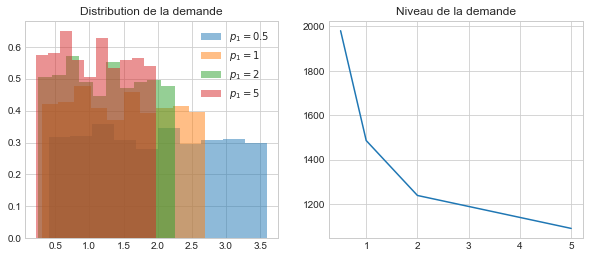

In [9]:
fig = plt.figure(figsize=(10,4))

ax_left = fig.add_subplot(1,2,1)
ax_left.set_title('Distribution de la demande')
for i,p1 in enumerate(p1_vec):
    ax_left.hist(dists[i],density=True,alpha=0.5,label=f'$p_1 = {p1}$')
ax_left.legend(loc='upper right')

ax_right = fig.add_subplot(1,2,2)
ax_right.set_title('Niveau de la demande')
ax_right.grid(True)
ax_right.plot(p1_vec,totaux)

### <center> FIGURES INTERACTIVES</center>

Définition d'une fonction pour construire un graphique,

In [10]:
def graphique_interactif(alphas,p1,p2,k):
    
    # a. calculs
    dist,_total = calcul_demande_q1(alphas,p1,p2,k)
    
    # b. graphique
    fig = plt.figure(dpi=100)
    ax = fig.add_subplot(1,1,1)
    ax.hist(dist,density=True)
    ax.set_xlim([0,4]) # rang pour les x fixe
    ax.set_ylim([0,0.8]) # rang pour les x fixe

**Cas 1:** graphique interactif avec **curseur(slider)**

In [11]:
widgets.interact(graphique_interactif,
    alphas=widgets.fixed(alphas),
    p1=widgets.FloatSlider(description='$p_1$', min=0.1, max=5, step=0.05, value=2),
    p2=widgets.fixed(p2),
    k=widgets.fixed(k)
);

interactive(children=(FloatSlider(value=2.0, description='$p_1$', max=5.0, min=0.1, step=0.05), Output()), _do…

**Cas 2:** graphique interactif avec **champ de saisie**

In [12]:
widgets.interact(graphique_interactif,
    alphas=widgets.fixed(alphas),
    p1=widgets.FloatText(description = "$p_1$", value=2),
    p2=widgets.fixed(p2),
    k=widgets.fixed(k)
);

interactive(children=(FloatText(value=2.0, description='$p_1$'), Output()), _dom_classes=('widget-interact',))

**Cas 3:** graphique interactif avec **menu déroulant**

In [13]:
widgets.interact(graphique_interactif,
    alphas=widgets.fixed(alphas),
    p1=widgets.Dropdown(description="$p_1$", options=[0.5,1,1.5,2.0,2.5,3], value=2),
    p2=widgets.fixed(p2),
    k=widgets.fixed(k)
);

interactive(children=(Dropdown(description='$p_1$', index=3, options=(0.5, 1, 1.5, 2.0, 2.5, 3), value=2.0), O…

**Exercice:** ajoutez un curseur pour \\(k\\) dans le graphique ci-dessous.

In [ ]:
# code à modifier
widgets.interact(graphique_interactif,
    alphas=widgets.fixed(alphas),
    p1=widgets.FloatSlider(description="$p_1$", min=0.1, max=5, step=0.05, value=2),
    p2=widgets.fixed(p2),
    k=widgets.fixed(k)
);

### <center> ÉQUILIBRE</center>

Les conditions d'équilibre (demande = offre) sont:

$$
\begin{align*}
\sum_{j=1}^n q_{1}^{\star j}(p_{1},p_{2},e^{j}) &= nk \Leftrightarrow Z_1 := \sum_{j=1}^n q_{1}^{\star j}(p_{1},p_{2},e^{j}) - nk = 0 \\
\sum_{j=1}^n q_{2}^{\star j}(p_{1},p_{2},e^{j}) &= n \Leftrightarrow Z_2 := \sum_{j=1}^n q_{2}^{\star j}(p_{1},p_{2},e^{j}) - n = 0
\end{align*}
$$

**Idée:** résoudre la première équation, la seconde étant alors vérifiée du fait de la loi de Walras.

**Fonctions d'excès de demande:**

In [14]:
def fn_exces_demande_q1(alphas,p1,p2,k):
    
    # a. demande
    demande = np.sum(fn_demande_q1(alphas,p1,p2,k))
    
    # b. offre
    offre = k*alphas.size
    
    # c. excès de demande
    exces_demande = demande-offre
    
    return exces_demande

def fn_exces_demande_q2(alphas,p1,p2,k):
    
    # a. demande
    demande = np.sum(fn_demande_q2(alphas,p1,p2,k))
    
    # b. offre
    offre = alphas.size
    
    # c. excès de demande
    exces_demande = demande-offre
    
    return exces_demande

**Algorithme:**  
On choisit d'abord un paramètre de **tolérance** $\epsilon > 0$ et un **facteur d'ajustement** $\kappa$, et une valeur de départ $p_1 > 0$. 

On cherche le prix d'équilibre par:

1. Calcul de l'excès de demande $Z_1 = \sum_{j=1}^n q_{1}^{\star j}(p_{1},p_{2},e^{j}) - nk$,
2. Si $|Z_1| < \epsilon $ alors on arrête,
3. Si $|Z_1| \geq \epsilon $ on calcule/actualise $p_1 = p_1 + \kappa \cdot \frac{Z_1}{n}$,
4. On revient l'étape 1 $\ldots$.

C.à.d: si l'excès de demande est positif et loin de 0 on augmente le prix, et si l'excès de demande est négatif et loin de 0 on diminue le prix.


In [15]:
def fn_prix_equilibre(alphas,p1,p2,k,kappa=0.5,eps=1e-8,maxiter=500):
    
    t = 0
    while True:

        # a. étape 1: excès de demande
        Z1 = fn_exces_demande_q1(alphas,p1,p2,k)
        
        # b: étape 2: arrêt?
        if  np.abs(Z1) < eps or t >= maxiter:
            print(f'{t:3d}: p1 = {p1:12.8f} -> excès de demande -> {Z1:14.8f}')
            break    
    
        # c. étape 3: on actualise p1
        p1 = p1 + kappa*Z1/alphas.size
            
        # d. étape 4: affichage seulement à chaque 25ème boucle en utilisant l'opérateur modulo
        if t < 5 or t%25 == 0:
            print(f'{t:3d}: p1 = {p1:12.8f} -> excès de demande -> {Z1:14.8f}')
        elif t == 5:
            print('   ...')
            
        t += 1    

    return p1

Prix d'équilibre

In [16]:
p1 = 1.4
p2 = 1
kappa = 0.1
eps = 1e-8
p1 = fn_prix_equilibre(alphas,p1,p2,k,kappa=kappa,eps=eps)

  0: p1 =   1.33439880 -> excès de demande ->  -656.01196112
  1: p1 =   1.27053636 -> excès de demande ->  -638.62442997
  2: p1 =   1.20853906 -> excès de demande ->  -619.97297877
  3: p1 =   1.14854100 -> excès de demande ->  -599.98058426
  4: p1 =   1.09068322 -> excès de demande ->  -578.57782128
   ...
 25: p1 =   0.51008953 -> excès de demande ->   -48.02909064
 50: p1 =   0.49046505 -> excès de demande ->    -0.16854647
 75: p1 =   0.49040023 -> excès de demande ->    -0.00052951
100: p1 =   0.49040003 -> excès de demande ->    -0.00000166
123: p1 =   0.49040003 -> excès de demande ->    -0.00000001


**Vérification:** on vérifie que l'excès de demande pour les deux biens est pratiquement zéro.

In [ ]:
Z1 = fn_exces_demande_q1(alphas,p1,p2,k)
Z2 = fn_exces_demande_q2(alphas,p1,p2,k)
print(Z1,Z2)
assert np.abs(Z1) < eps
assert np.abs(Z2) < eps

### <center> INTÉGRATION NUMÉRIQUE PAR MONTE-CARLO</center>

Le calcul numérique d'intégrales consiste à calculer,

$$ 
\operatorname{E}[g(X)]  \text{ où } X \sim F
$$

où $F$ est une loi de probabilité connue et $g$ est une fonction. 

On s'appuyant sur la loi des grands nombres, une approximation de cette intégrale est,

$$
\operatorname{E}[g(X)]  \approx \frac{1}{n}\sum_{i=1}^{n} g(X_i) 
$$

où $X_i$ est un tirage à partir de $F$ en utilisant un générateur de nombres aléatoires. Cette procédure est appelée **intégration numériques par méthodes de Monte-Carlo**.

**Fonction de Monte-Carlo**

In [ ]:
def g(x):
    return (x-1)**2

def MC(n,g,F):
    X = F.rvs(size=n) # rvs = tirage de n nombres aléatoires à partir de F
    return np.mean(g(X))

**Exemple** avec une loi normale:

In [ ]:
n = 1000
mu = 0.1
sigma = 0.5
F = norm(loc=mu,scale=sigma)
print(MC(n,g,F))

Fonction pour tirer $k$ échantillons de Monte-Carlo:

In [ ]:
def MC_echantillon(n,g,F,k):
    
    resultats = np.empty(k)
    for i in range(k):
        resultats[i] = MC(n,g,F)

    return resultats

La variance sur les échantillons de Monte-Carlo diminue quand $n$ devient grand:

In [ ]:
k = 1000
for n in [10**2,10**3,10**4,10**5]:
    resultats = MC_echantillon(n,g,F,k)
    print(f'n = {n:8d}: {resultats.mean():.6f} (std: {resultats.std():.4f})')

In [ ]:
import session_info
session_info.show()

### <center> AVANCÉ: QUADRATURE DE GAUSS-HERMITE</center>

**Problème:** l'intégration numérique par MC est **lente**.

**Solution:** utiliser des formules d'intégration plus malignes sur la forme

$$
\operatorname{E}[g(X)] \approx \sum_{i=1}^{n} w_ig(X_i) 
$$

où $(X_i,w_i), \forall n \in \{1,2,\dots,n\}$, sont appelés **noeuds et poids de la quadrature ** et résultent par une formule théorique qui dépend de la loi de $X$.

**Exemple I, loi normale:** si $X \sim \mathcal{N}(\mu,\sigma)$ alors on peut utiliser la [quadrature de Gauss-Hermite](https://fr.wikipedia.org/wiki/M%C3%A9thodes_de_quadrature_de_Gauss#M%C3%A9thode_de_Gauss-Hermite) mise en oeuvre ci-dessous.

In [ ]:
def gauss_hermite(n):
    """ noeuds de gauss-hermite 

    Args:

        n (int): nombre de points

    Renvois:

        x (numpy.ndarray): noeuds de longueur n
        w (numpy.ndarray): poids de longueur n

    """

    # a. calculs
    i = np.arange(1,n)
    a = np.sqrt(i/2)
    CM = np.diag(a,1) + np.diag(a,-1)
    L,V = np.linalg.eig(CM)
    I = L.argsort()
    V = V[:,I].T

    # b. noeuds et poids
    x = L[I]
    w = np.sqrt(math.pi)*V[:,0]**2

    return x,w

In [ ]:
def normal_gauss_hermite(sigma, n=7, mu=None, exp=False):
    """ noeuds de gauss-hermite dans le cas de loi normale

    Args:

        sigma (double): écart-type
        n (int): nombre de points
        mu (double,optionnel): moyenne
        exp (bool,optionnel): prends exp et corrige la moyenne (si cela n'est pas spécifié)

    Renvois:

        x (numpy.ndarray): noeuds de longueur n
        w (numpy.ndarray): poids de longueur n

    """

    if sigma == 0.0 or n == 1:
        x = np.ones(n)
        if mu is not None:
            x += mu
        w = np.ones(n)
        return x,w

    # a. GaussHermite
    x,w = gauss_hermite(n)
    x *= np.sqrt(2)*sigma 

    # b. log-normalité
    if exp:
        if mu is None:
            x = np.exp(x - 0.5*sigma**2)
        else:
            x = np.exp(x + mu)
    else:
        if mu is None:
            x = x 
        else:
            x = x + mu

    w /= np.sqrt(math.pi)

    return x,w

**Résultats:** comme la fonction n'est pas "difficile", peu de points de quadrature sont requis ici (*ceci n'est en généralement pas le cas*).

In [ ]:
for n in [1,2,3,5,7,9,11]:
    x,w = normal_gauss_hermite(mu=mu,sigma=sigma,n=n)
    result = np.sum(w*g(x))
    print(f'n = {n:3d}: {result:.10f}')

**Example II, loi log-normale ([plus ici](https://fr.wikipedia.org/wiki/Loi_log-normale)):** 

1. Soit $\log X \sim \mathcal{N}(\mu,\sigma)$. 
2. La quadrature de Gauss-Hermite avec noeuds et poids peut être utilisée avec l'option `exp=True`. 
3. Pour garantir $\operatorname{E}(X) = 1$ alors $\mu = -0.5\sigma^2$.

In [ ]:
z = np.random.normal(size=1_000_000,scale=sigma)

print('moyenne(x) quand mu = 0')
x,w = normal_gauss_hermite(mu=0,sigma=sigma,n=7,exp=True)
print(f'MC: {np.mean(np.exp(z)):.4f}')
print(f'Gauss-Hermite: {np.sum(x*w):.4f}')
print('')

print('moyenne(x), mu = -0.5*sigma^2')
x,w = normal_gauss_hermite(sigma=sigma,n=7,exp=True)
print(f'MC: {np.mean(np.exp(z)-0.5*sigma**2):.4f}')
print(f'Gauss-Hermite: {np.sum(x*w):.4f}')

### <center> CHARGER ET SAUVEGARDER</center>

### Pickle

Une bonne façon générale pour charger et sauvegarder est d'utiliser **pickle**. Voici pour la sauvegarde:



In [ ]:
# a. variables
mon_dict = {'a':1,'b':2}
mon_vec = np.array([1,2,3])
mon_tupple = (1,4,2)

# b. on les place dans un dictionnaire
mes_donnees = {}
mes_donnees['mon_dict'] = mon_dict
mes_donnees['mon_vec'] = mon_vec
mes_donnees['mon_tupple'] = mon_tupple

# c. sauvegarde du dictionnaire dans un fichier
with open(f'donnees.p', 'wb') as f: # wb = write binary
    pickle.dump(mes_donnees, f)

Suppression des variables:

In [ ]:
del mon_dict
del mon_vec
del mon_tupple

On recharge les données

In [ ]:
# a. essai
try:
    print(mon_tupple)
except:
    print('mon_tupple n\'existe pas')
    
# b. chargement    
with open(f'donnees.p', 'rb') as f: # rb = read binary
    donnees = pickle.load(f)
    mon_dict = donnees['mon_dict']
    mon_vec = donnees['mon_vec']
    mon_tupple = donnees['mon_tupple']
    
# c. encore un essai
print(mon_vec)
print(mon_tupple)

### Numpy

Quand il s'agit de seulement sauvegarder des arrays numpy, une alternative est d'utiliser ``np.savez`` (ou ``np.savez_compressed``). Typiquement, cela est plus rapide que pickle.

Voici un exemple:

In [ ]:
mes_donnees = {}
mes_donnees['A'] = np.array([1,2,3])
mes_donnees['B'] = np.zeros((5,8))
mes_donnees['C'] = np.ones((7,3,8))
np.savez(f'data.npz', **mes_donnees)
# '**' défaire le dictionaire

On recharge les données

In [ ]:
# a. suppression
del mes_donnees

# a. chargement de tout
mes_donnees = {}
with np.load(f'data.npz') as data_obj:
    for key in data_obj.files:
        mes_donnees[key] = data_obj[key]
print(mes_donnees['A'])

# b. chargement d'un seul array
X = np.load(f'data.npz')['A']
print(X)

### <center> RÉSUMÉ</center>

**Ce cours:** nous avons traité:

1. numpy.random: tirage de nombres (pseudo-)aléatoires (graine, état, lois)
2. scipy.stats: utilisation de lois de probabilité analytiques (ppf, pdf, cdf, rvs)
3. ipywidgets: graphiques interactifs
4. pickle et np.savez: sauvegarde et chargement de donnees

Les méthodes employées pour trouver l'équilibre peuvent aussi l'être pour de nombreux autres modèles. Par exemple, une méthode simple avec plusieurs biens.


# Exercices




## Tirage de nombre aléatoires

Dans le code ci-après remplacez les lignes manquantes de manière à obtenir les résultats qui suivent.

In [17]:
import numpy as np
np.random.seed(1986)
# ligne manquante
for i in range(3):
    # ligne manquante
    for j in range(2):
        x = np.random.uniform()
        print(f'({i},{j}): x = {x:.3f}')

(0,0): x = 0.569
(0,1): x = 0.077
(1,0): x = 0.608
(1,1): x = 0.897
(2,0): x = 0.545
(2,1): x = 0.703


## Réponse:

In [18]:
import numpy as np
np.random.seed(1986)
state = np.random.get_state()
for i in range(3):
    np.random.set_state(state)
    for j in range(2):
        x = np.random.uniform()
        print(f'({i},{j}): x = {x:.3f}')

(0,0): x = 0.569
(0,1): x = 0.077
(1,0): x = 0.569
(1,1): x = 0.077
(2,0): x = 0.569
(2,1): x = 0.077


## Calcul de l'espérance et variance d'un v.a.

Calculez l'espérance et variance

$$ 
\operatorname{E}[g(X)] \approx \frac{1}{n}\sum_{i=1}^{n} g(X_i)
$$
$$ 
\operatorname{Var}[g(X)] \approx \frac{1}{n}\sum_{i=1}^{n} \left( g(X_i) - \frac{1}{n}\sum_{i=1}^{n} g(X_i) \right)^2
$$

où $ X_i \sim \mathcal{N}(0,\sigma) $ et

$$ 
g(x,\omega)=\begin{cases}
x & \text{if }x\in[-\omega,\omega]\\
-\omega & \text{if }x<-\omega\\
\omega & \text{if }x>\omega
\end{cases} 
$$

In [19]:
sigma = 3.14
omega = 2
n = 10000
np.random.seed(1986)
# votre réponse ci-dessous



In [20]:
# a. choix des paramètres
sigma = 3.14
omega = 2
N = 10000
np.random.seed(1986)

# b. tirage de nombres aléatoires selon une loi normale
x = np.random.normal(loc=0,scale=sigma,size=N)

# c. fonction de transformation
def g(x,omega):
    y = x.copy()
    y[x < -omega] = -omega
    y[x > omega] = omega
    return y

# d. moyenne et variance
mean = np.mean(g(x,omega))
var = np.var(g(x-mean,omega))
print(f'moyenne = {mean:.5f}, variance = {var:.5f}')
    

moyenne = -0.00264, variance = 2.69804


## Histogramme interactif

**Première partie:** dans le code ci-dessous complétez les lignes manquantes pour avoir le graph de la figure.

In [21]:
# a. imports
%matplotlib inline
import matplotlib.pyplot as plt
# ligne à compléter

# b. graph de la figure
def fitting_normal(X,mu_init,sigma_init):
    
    # i. loi normale à partir des paramètres initiaux(mu_init, sigma_init)
    F = norm(loc=mu_init,scale=sigma_init)
    
    # ii. valeurs de x
    # a compléter, x_inf =
    # a compléter, x_sup =
    x = np.linspace(x_inf,x_sup,100)

    # iii. graphique
    fig = plt.figure(dpi=100)
    ax = fig.add_subplot(1,1,1)
    ax.plot(x,F.pdf(x),lw=2)
    ax.hist(X,bins=100,density=True,histtype='stepfilled');
    ax.set_ylim([0,0.5])
    ax.set_xlim([-6,6])

# c. paramètres
mu_vrai = 2
sigma_vrai = 1
mu_init = 1
sigma_init = 2

# d. tirages aléatoires
X = np.random.normal(loc=mu_vrai,scale=sigma_vrai,size=10**6)

# e. graphique
try:
    fitting_normal(X,mu_init,sigma_init)
except:
    print('échec')

échec


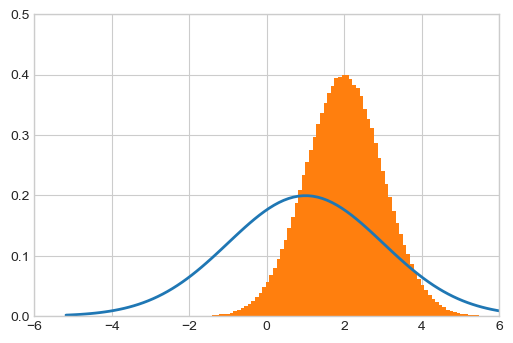

In [22]:
# a. imports
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm

# b. graph de la figure
def fitting_normal(X,mu_init,sigma_init):
    
    # i. loi normale à partir des paramètres initiaux(mu_init, sigma_init)
    F = norm(loc=mu_init,scale=sigma_init)
    
    # ii. valeurs de x
    x_inf = F.ppf(0.001) # valeur de x où la fonction de répartition est 0.001
    x_sup = F.ppf(0.999) # valeur de x où la fonction de répartition est 0.999
    x = np.linspace(x_inf,x_sup,100)

    # iii. graphique
    fig = plt.figure(dpi=100)
    ax = fig.add_subplot(1,1,1)
    ax.plot(x,F.pdf(x),lw=2)
    ax.hist(X,bins=100,density=True,histtype='stepfilled');
    ax.set_ylim([0,0.5])
    ax.set_xlim([-6,6])

# c. paramètres
mu_vrai = 2
sigma_vrai = 1
mu_init = 1
sigma_init = 2

# d. tirages aléatoires
X = np.random.normal(loc=mu_vrai,scale=sigma_vrai,size=10**6)

# e. graphique
try:
    fitting_normal(X,mu_init,sigma_init)
except:
    print('échec')

**Deuxième partie:** création d'une figure interactive avec défilement(sliders) pour $\mu$ et $\sigma$.

In [24]:
# Réponse
import ipywidgets as widgets
widgets.interact(fitting_normal,
    X=widgets.fixed(X),
    mu_init=widgets.FloatSlider(description="$\mu$", min=0.1, max=5, step=0.05, value=1),
    sigma_init=widgets.FloatSlider(description="$\sigma$", min=0.1, max=5, step=0.05, value=1)
);

interactive(children=(FloatSlider(value=1.0, description='$\\mu$', max=5.0, min=0.1, step=0.05), FloatSlider(v…

## Sauvegarde et lecture

Considérez le code ci-dessous et complétez les lignes manquantes de sorte qu'il n'y ait pas d'erreur lors de l'execution.

In [ ]:
import pickle

# a. création de données
mes_donnees = {}
mes_donnees['A'] = {'a':1,'b':2}
mes_donnees['B'] = np.array([1,2,3])
# ligne manquante

mes_donnees_np = {}
mes_donnees_np['D'] = np.array([1,2,3])
mes_donnees_np['E'] = np.zeros((5,8))
# ligne manquante

# c. sauvegarde avec pickle
with open(f'donnees.p', 'wb') as f:
    # ligne manquante
    pass
    
# d. sauvegarde avec numpy
# ligne manquante, np.savez(?)
    
# a. essai du code
def load_all():
    with open(f'donnees.p', 'rb') as f:
        donnees = pickle.load(f)
        A = donnees['A']
        B = donnees['B']
        C = donnees['C']

    with np.load(f'donnees.npz') as donnees:
        D = donnees['D']
        E = donnees['E']
        F = donnees['F']        
    
    print('chargement des variables sans erreur')
    
try:
    load_all()
except:
    print('échec')

In [26]:
# Réponse

import pickle

# a. création de donnees
mes_donnees = {}
mes_donnees['A'] = {'a':1,'b':2}
mes_donnees['B'] = np.array([1,2,3])
mes_donnees['C'] = (1,4,2)

mes_donnees_np = {}
mes_donnees_np['D'] = np.array([1,2,3])
mes_donnees_np['E'] = np.zeros((5,8))
mes_donnees_np['F'] = np.ones((7,3,8))

# c. save with pickle
with open(f'donnees.p', 'wb') as f:
    pickle.dump(mes_donnees, f)
    
# d. save with numpy
np.savez(f'donnees.npz', **mes_donnees_np)
    
# a. try
def load_and_print():
    with open(f'donnees.p', 'rb') as f:
        donnees = pickle.load(f)
        A = donnees['A']
        B = donnees['B']
        C = donnees['C']

    with np.load(f'donnees.npz') as donnees:
        D = donnees['D']
        E = donnees['E']
        F = donnees['F']        

    print('chargement des variables sans erreur')
            
try:
    load_and_print()
except:
    print('une erreur est trouvée')

chargement des variables sans erreur


## Modules

1. Faites un appel `ma_fct` dans le module `mon_module` dans ce dossier.
2. Ouvrez `mon_module.py` avec vscode ou spyder(via "anaconda navigator"),et ajoutez une nouvelle fonction que vous appellerez à partir de ce notebook.

In [ ]:
# votre code ici

**Réponse:**

In [1]:
import mon_module
mon_module.ma_fct(5)

hello world!
hello world!
hello world!
hello world!
hello world!


In [2]:
mon_module.ma_fct_bis(5)

bonjour!
bonjour!
bonjour!
bonjour!
bonjour!


# Problème

Soit une **économie d'échange** avec

1. 2 biens, $(q_1,q_2)$
2. $n$ consommateurs indicés par $j \in \{1,2,\dots,n\}$
3. Préférences de type Cobb-Douglas des coefficients *hétérogènes* selon une loi normale tronquée.

    $$
    \begin{align*}
    u^{j}(q_{1},q_{2}) & = q_{1}^{\alpha_{j}}q_{2}^{1-\alpha_{j}}\\
     \tilde{\alpha}_{j}&\sim\mathcal{N}(\mu,\sigma)\\
     \alpha_j &= \max(\underline{\mu},\min(\overline{\mu},\tilde{\alpha}_{j}))
    \end{align*}
    $$

4. dotations hétérogènes et données par

    $$
    \begin{align*}
    \boldsymbol{e}^{j}&=(e_{1}^{j},e_{2}^{j}) \\
     e_i^j &\sim f, f(x,\beta_i) =  1/\beta_i \exp(-x/\beta)
    \end{align*}
    $$

**Problème:** écrivez une fonction pour résoudre l'équilibre

Vous pouvez utiliser les paramètres suivantes

In [ ]:
# a. paramètres
n = 10000
mu = 0.5
sigma = 0.2
mu_inf = 0.1
mu_sup = 0.9
beta1 = 1.3
beta2 = 2.1
seed = 1986

# b. tirage de nombre aléatoires
# c. fonction de demande
# d. excès de demande
# e. fonction pour obtenir l'équilibre
# f. appel de la fonction en e)

**Indication:** la structure du code est exactement la même que pour l'économie d'échange traitée au début de le cours de ce notebook. Il est reproduit ici de façon condensée:

In [ ]:
# a. paramètres
N = 1000
k = 2
mu_inf = 0.1
mu_sup = 0.9
seed = 1986

# b. tirage de nombre aléatoires
np.random.seed(seed)
alphas = np.random.uniform(low=mu_inf,high=mu_sup,size=n)

# c. fonction de demande
def fn_demande_q1(alpha,p1,p2,k):
    R = k*p1+p2
    return alpha*R/p1

# d. excès de demande
def fn_exces_demande_q1(alphas,p1,p2,k):
    
    # a. demande
    demande = np.sum(fn_demande_q1(alphas,p1,p2,k))
    
    # b. offre
    offre = k*alphas.size
    
    # c. excès de demande
    exces_demande = demande-offre
    
    return exces_demande

# e. fonction pour calcul de prix d'équilibre
def fn_prix_equilibre(alphas,p1,p2,k,kappa=0.5,eps=1e-8,maxiter=500):
    
    t = 0
    while True:

        # a. étape 1: excès de demande
        Z1 = fn_exces_demande_q1(alphas,p1,p2,k)
        
        # b: étape 2: arrêt?
        if  np.abs(Z1) < eps or t >= maxiter:
            print(f'{t:3d}: p1 = {p1:12.8f} -> excès de demande -> {Z1:14.8f}')
            break    
    
        # c. step 3: actualisation de p1
        p1 = p1 + kappa*Z1/alphas.size
            
        # d. step 4: résultat
        if t < 5 or t%25 == 0:
            print(f'{t:3d}: p1 = {p1:12.8f} -> excès de demande -> {Z1:14.8f}')
        elif t == 5:
            print('   ...')
            
        t += 1    

    return p1

# e. appel de la fonction pour prix d'équilibre
p1 = 1.4
p2 = 1
kappa = 0.1
eps = 1e-8
p1 = fn_prix_equilibre(alphas,p1,p2,k,kappa=kappa,eps=eps)

**Réponses:**

In [5]:
# a. paramètres
n = 10000
mu = 0.5
sigma = 0.2
mu_inf = 0.1
mu_sup = 0.9
beta1 = 1.3
beta2 = 2.1
seed = 1986

# b. tirage de nombre aléatoires
np.random.seed(seed)
alphas = np.random.normal(loc=mu,scale=sigma,size=n)
alphas = np.fmax(np.fmin(alphas,mu_sup),mu_inf)
e1 = np.random.exponential(beta1,size=n)
e2 = np.random.exponential(beta2,size=n)

# c. fonction de demande du bien 1
def fn_demand_q1(alpha,p1,p2,e1,e2):
    R = p1*e1+p2*e2
    return alpha*R/p1

# d. excès de demande du bien 1
def fn_exces_demande_q1(alphas,p1,p2,e1,e2):
    
    # a. demande
    demande = np.sum(fn_demand_q1(alphas,p1,p2,e1,e2))
    
    # b. offre
    offre = np.sum(e1)
    
    # c. excès de demande
    exces_demande = demande-offre
    
    return exces_demande

# e. fonction pour calcul de prix d'équilibre
def fn_prix_equilibre(alphas,p1,p2,e1,e2,kappa=0.5,eps=1e-8,maxiter=500):
    
    t = 0
    while True:

        # a. étape 1: excès de demande
        Z1 = fn_exces_demande_q1(alphas,p1,p2,e1,e2)
        
        # b: étape 2= arrêt
        if  np.abs(Z1) < eps or t >= maxiter:
            print(f'{t:3d}: p1 = {p1:12.8f} -> excès de demande -> {Z1:14.8f}')
            break    
    
        # c. étape 3: actualisation de p1
        p1 = p1 + kappa*Z1/alphas.size
            
        # d. step 4: résultat
        if t < 5 or t%25 == 0:
            print(f'{t:3d}: p1 = {p1:12.8f} -> excès de demande -> {Z1:14.8f}')
        elif t == 5:
            print('   ...')
            
        t += 1    

    return p1

# f. appel de la fonction pour prix d'équilibre
p1 = 1.4
p2 = 1
kappa = 0.5
eps = 1e-8
p1 = fn_prix_equilibre(alphas,p1,p2,e1,e2,kappa=kappa,eps=eps)

  0: p1 =   1.45140633 -> excès de demande ->  1028.12662815
  1: p1 =   1.48943510 -> excès de demande ->   760.57530384
  2: p1 =   1.51816180 -> excès de demande ->   574.53408777
  3: p1 =   1.54017076 -> excès de demande ->   440.17912761
  4: p1 =   1.55720246 -> excès de demande ->   340.63398830
   ...
 25: p1 =   1.62002594 -> excès de demande ->     2.71044780
 50: p1 =   1.62056127 -> excès de demande ->     0.00980814
 75: p1 =   1.62056320 -> excès de demande ->     0.00003553
100: p1 =   1.62056321 -> excès de demande ->     0.00000013
112: p1 =   1.62056321 -> excès de demande ->     0.00000001
